<a href="https://colab.research.google.com/github/saadz-khan/Text2Image/blob/master/pixray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import os
#@title Setup

#@markdown Please execute this cell by pressing the _Play_ button (Only one time on new account)  

# Add a gpu check
nvidia_output = !nvidia-smi --query-gpu=memory.total --format=noheader,nounits,csv
gpu_memory = int(nvidia_output[0])
if gpu_memory < 14000:
  print(f"--> GPU check: ONLY {gpu_memory} MiB available: WARNING, some things might not work <--")
else:
  print(f"GPU check: {gpu_memory} MiB available: this should be fine")

print("Installing...")
if os.path.exists('/content/drive/MyDrive/pixray'):
  pass
else:
    %mkdir /content/drive/MyDrive/pixray
%cd /content/drive/MyDrive/pixray
from IPython.utils import io
with io.capture_output() as captured:
  !rm -Rf pixray
  !git clone --recursive https://github.com/pixray/pixray
  #!pip install -r pixray/requirements.txt
  #!pip uninstall -y tensorflow 
  !git clone https://github.com/pixray/diffvg
  #%cd diffvg
  #!git submodule update --init --recursive
  #!python setup.py install
  #%cd ..
  #!pip freeze | grep torch
  !mkdir -p models

GPU check: 16280 MiB available: this should be fine
Installing...
/content/drive/MyDrive/pixray


In [ ]:
#@title Installing and loading libraries 

%cd /content/drive/MyDrive/pixray
import os
from IPython.utils import io
with io.capture_output() as captured:
  !pip install -r pixray/requirements.txt
  !pip uninstall -y tensorflow 
  %cd diffvg
  !git submodule update --init --recursive
  !python setup.py install
  %cd ..
  !pip freeze | grep torch
  !pip install gradio==2.3.7
  os.kill(os.getpid(), 9)


/content/drive/MyDrive/pixray


# User Interface

**Textfile (txt) format that can be added**   
'@' is used as a seperator for defining the number of times each prompt needs to be repeated

```Prompt 1@2```  
```Prompt 2@1```




In [ ]:
#@title User Interface
#@markdown Click the link that is generated below (https.*****.gradio.app) after clicking the __Play__ button
import gradio as gr
import torch
import sys
sys.path.append("pixray")
%cd /content/drive/MyDrive/pixray
import pixray
from PIL import Image

# Define the main function
def generate(prompt, quality, style, width, height, repeat, folder_name, iterations, vqgan_model, loss, init_image, txt):
  %cd /content/drive/MyDrive/pixray
  punctuations = '''|!()-[]{};:'"\,<>./?@#$%^&*_~'''

  try:
    path = r'/content/init.png'
    im = Image.fromarray(init_image)
    im.save(path)
  except: 
    path = None

  if (txt):
    with open(txt.name) as file1:
      for f in file1.readlines():
        try:
          repeat = int(f.split('@')[1])
        except:
          repeat = 1

        for k in range(repeat):
          no_punct = ""
          for char in f.split('@')[0]:
            if char not in punctuations:
                no_punct = no_punct + char
          torch.cuda.empty_cache()
          pixray.reset_settings()

          if (style=='vqgan'):
            pixray.add_settings(vqgan_model=vqgan_model)
          if (path!=None and style=='vdiff'):
            pixray.add_settings(vdiff_skip=20)

          pixray.add_settings(prompts=f.split('@')[0],
                              quality=quality,
                              size=[int(width),int(height)],
                              drawer=style,
                              iterations=int(iterations),
                              init_image=path,
                              custom_loss = loss,
                              make_video=False,
                              output=no_punct + str(k),
                              outdir=f'/content/drive/MyDrive/pixray/experiments/{folder_name}'
                              )

          settings = pixray.apply_settings()
          pixray.do_init(settings)
          pixray.do_run(settings)

    return f'/content/drive/MyDrive/pixray/experiments/{folder_name}/{no_punct + str(k)}.png'#, f'/content/drive/MyDrive/pixray/experiments/{folder_name}/{no_punct + str(k)}.mp4'
  


  else:
    repeat = int(repeat)
    if (repeat != 1):
      for k in range(repeat):
        no_punct = ""
        for char in prompt:
          if char not in punctuations:
            no_punct = no_punct + char
        torch.cuda.empty_cache()
        pixray.reset_settings()

        if (style=='vqgan'):
            pixray.add_settings(vqgan_model=vqgan_model)
        if (path!=None and style=='vdiff'):
          pixray.add_settings(vdiff_skip=20)
        
        pixray.add_settings(prompts=prompt,
                            quality=quality,
                            size=[int(width),int(height)],
                            iterations=int(iterations),
                            custom_loss = loss,
                            drawer=style,
                            init_image = path,
                            make_video=False,
                            output=no_punct + str(k),
                            outdir=f'/content/drive/MyDrive/pixray/experiments/{folder_name}'
                            )

        settings = pixray.apply_settings()
        pixray.do_init(settings)
        pixray.do_run(settings)

        
    no_punct = ""
    for char in prompt:
      if char not in punctuations:
          no_punct = no_punct + char
    torch.cuda.empty_cache()
    pixray.reset_settings()

    if (style=='vqgan'):
        pixray.add_settings(vqgan_model=vqgan_model)
    if (path!=None and style=='vdiff'):
        pixray.add_settings(vdiff_skip=20)
    
    pixray.add_settings(prompts=prompt,
                        quality=quality,
                        size=[int(width),int(height)],
                        iterations=int(iterations),
                        drawer=style,
                        custom_loss = loss,
                        init_image = path,
                        make_video=False,
                        output=no_punct,
                        outdir=f'/content/drive/MyDrive/pixray/experiments/{folder_name}'
                        )

    settings = pixray.apply_settings()
    pixray.do_init(settings)
    pixray.do_run(settings)

    return f'/content/drive/MyDrive/pixray/experiments/{folder_name}/{no_punct}.png'#, f'/content/drive/MyDrive/pixray/experiments/{folder_name}/{no_punct}.mp4'

# Create the UI
prompt = gr.inputs.Textbox(default="Underwater city by thomas kinkade", label="Text Prompt")
width = gr.inputs.Number(label="Width", default=550)
height = gr.inputs.Number(label="Height", default=800)
style = gr.inputs.Radio(choices=['vqgan', 'vdiff','pixel'], label="Drawer", default='vqgan')
vqgan_model = gr.inputs.Radio(choices=['wikiart_16384','imagenet_f16_16384'], label="VQGAN_model", default = 'wikiart_16384')
loss = gr.inputs.Radio(choices=['None', 'aesthetic'], label="Loss", default='None')
quality = gr.inputs.Radio(choices=['draft', 'normal', 'better', 'best','supreme'], label="Quality", default = 'supreme')
init_image = gr.inputs.Image(label = 'Initial Image', optional=True)
folder_name = gr.inputs.Textbox(default="new", label="Folder Name")
txt = gr.inputs.File(label='Text file for batching', optional=True)
repeat = gr.inputs.Number(default=1, label='Repeat')
iterations = gr.inputs.Number(default=200, label='iterations')

#video = gr.inputs.Checkbox(label='Video')

# Launch the demo
iface = gr.Interface(generate, inputs=[prompt, quality, style, width, height, repeat, folder_name, iterations, vqgan_model, loss, init_image, txt], outputs=['image', 'video'], enable_queue=True, live=False)
iface.launch(debug=True)

/content/drive/MyDrive/pixray
--> Super resolution drawer not supported No module named 'basicsr'
IMPORTANT: You are using gradio version 2.3.7, however version 2.5.1 is available, please upgrade.
--------
Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().

This share link expires in 72 hours. For free permanent hosting, check out Spaces (https://huggingface.co/spaces)
Running on public URL: https://50400.gradio.app
Interface loading below...


KeyboardInterrupt: ignored

# Helper Functions (not needed)

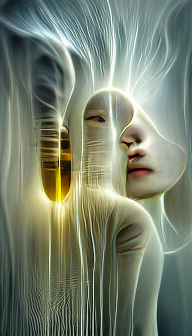

iter: 100, finished (-4=>3.465)



True

In [ ]:
 #@title Generate image from prompt { vertical-output: true }
import sys
import regex as re
import os
sys.path.append("pixray")
%cd /content/drive/MyDrive/pixray
import pixray


punctuations = '''|!()-[]{};:'"\,<>./?@#$%^&*_~'''

prompts = "all matter is merely energy condensed to a slow vibration, we are all one consciousness experiencing itself subjectively, there is no such thing as death, life is only a dream, and we are the imagination of ourselves artstation National Geographic Photo" #@param {type:"string"}

no_punct = ""
for char in prompts:
   if char not in punctuations:
       no_punct = no_punct + char

init_image = "/content/fakes000048 (3).jpg"#@param {type:"string"}
if os.path.isfile(init_image):
  pass
else: init_image = None

#init_image = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', init_image)
#init_image = re.findall('^/[\w\.\-]+$', init_image)

#target_image = ""#@param {type:"string"}
#target_image = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', init_image)

drawer = "vqgan" #@param ["vqgan", "pixel", "vdiff"]
vqgan_model = 'wikiart_16384' #@param ["imagenet_f16_1024","imagenet_f16_16384","imagenet_f16_16384m","openimages_f16_8192","coco","faceshq","wikiart_1024","wikiart_16384","wikiart_16384m","sflckr"]


width =  200 #@param{type:"number"}
height =  350 #@param{type:"number"}

video = False #@param {type:"boolean"}

display_clear = True #@param {type:"boolean"}

iterations =  100#@param {type:"number"}

quality = 'supreme' #@param ["draft", "normal", "better", "best", "supreme"]

#pixel_scale = 1 #@param {type:"slider", min:0.25, max:2.0, step:0.25}

num_cuts = 16 #@param {type:"slider", min:8, max:100, step:4}

batches =  4#@param{type:"number"}
#clip_models = #@param ["RN101","RN50x4","ViT-B/16", "ViT-B/32", "all"]

custom_loss = 'aesthetic' #@param ['aesthetic', 'aesthetic:0.5', 'None']

#if clip_models == "all":
  #clip_models = ["RN101","RN50x4","ViT-B/16", "ViT-B/32"]

optimiser = 'Adam' #@param ["Adam", "DiffGrad"]

palette = False #@param {type:"boolean"}
if palette:
  use_palette = "[#000000, #071008, #0e2011, #153019, #1c4022, #23502a, #2a6033, #31703b, #388044, #3f8f4c, #469f54, #4daf5d, #54bf65, #5bcf6e, #62df76, #69ef7f];black->white" #@param {type:"string"}
  pixray.add_settings(target_palette=use_palette)


pixray.reset_settings()
pixray.add_settings(prompts=prompts)
pixray.add_settings(quality=quality,
                    size=[width,height],
                    iterations=iterations,
                    drawer=drawer,
                    display_clear=display_clear,
                    make_video=video,
                    custom_loss=custom_loss,
                    #init_image=init_image,
                    #optimiser = optimiser,
                    init_image = init_image,
                    #batches = batches,
                    #num_cuts = num_cuts,
                    #vqgan_model = vqgan_model,
                    output = no_punct,
                    outdir = '/content/drive/MyDrive/pixray/experiments/idea1'
                    )

settings = pixray.apply_settings()
pixray.do_init(settings)
pixray.do_run(settings)


In [ ]:
#suff2 = ['Andrea Kowch','Adam Paquette','Alesso Baldovinetti','Alexander Jansen','Anton Semenov','Bastien Lecouffe Deharme','Bruno Pontiroli','By Jim Burns','By Thomas Kinkade','Craig Mullens','Cryengine','Cynthia Sheppard','Donato Giancola','Eddie Mendoza', 'Eiko Ishioka']

suff = ['Andrea Kowch','Adam Paquette','Alesso Baldovinetti','Alexander Jansen','Anton Semenov','Bastien Lecouffe Deharme','Bruno Pontiroli','Jim Burns','Thomas Kinkade','Craig Mullens','Cryengine','Cynthia Sheppard','Donato Giancola','Eddie Mendoza', 'Eiko Ishioka', 'Film Quality', 'Fugot Render','Gregory Crewdson','Gustave Dore','H R Giger','Hall Of Mirrors','Hyper Realism (+ Hyperrealism)','Ilford Hp5','Instax','Jacques Louis David','James Christensen','Jason A Engle','Jeff Wall','John Frederick Kensett','Julie Heffernan','Lawrence Lebduska','Louis Janmot','Luma Rouge', 'Macro Photography',"Magali Villeneuve",'Marc Simonetti','Michael Cheval','Naoto Hattori','National Geographic Photo','Neoclassicism','Odd Nerdrum','Photo Taken With Nikon D750','Pieter Claesz','Pre Raphaelite','Ralph Horsley','Religious Art','Rick Griffin','Roger Ballen','Sam Spratt','Scott M Fischer','Stephen Mackey','Terry Redlin','Tri X 400 Tx','Tyler Edlin','Zdzis aw Beksinski','Zdzislaw Beksinski']
#suff3 = ["Magali Villeneuve",'Marc Simonetti','Michael Cheval','Naoto Hattori','National Geographic Photo','Neoclassicism','Odd Nerdrum','Photo Taken With Nikon D750','Pieter Claesz','Pre Raphaelite','Ralph Horsley','Religious Art','Rick Griffin','Roger Ballen','Sam Spratt','Scott M Fischer','Stephen Mackey','Terry Redlin','Tri X 400 Tx','Tyler Edlin','Zdzis aw Beksinski','Zdzislaw Beksinski']


#@title Generate image from prompt { vertical-output: true }
import sys
import regex as re
import os
import torch
sys.path.append("pixray")
%cd /content/drive/MyDrive/pixray
import pixray
torch.cuda.empty_cache()

punctuations = '''|!()-[]{};:'"\,<>./?@#$%^&*_~'''

prompts = "all matter is merely energy condensed to a slow vibration, we are all one consciousness experiencing itself subjectively, there is no such thing as death, life is only a dream, and we are the imagination of ourselves artstation by " #@param {type:"string"}

"""no_punct = ""
for char in prompts:
   if char not in punctuations:
       no_punct = no_punct + char"""

init_image = ""#@param {type:"string"}
if os.path.isfile(init_image):
  pass
else: init_image = None

#init_image = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', init_image)
#init_image = re.findall('^/[\w\.\-]+$', init_image)

#target_image = ""#@param {type:"string"}
#target_image = re.findall('https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', init_image)

drawer = "vdiff" #@param ["vqgan", "pixel", "vdiff"]
vqgan_model = 'wikiart_16384' #@param ["imagenet_f16_1024","imagenet_f16_16384","imagenet_f16_16384m","openimages_f16_8192","coco","faceshq","wikiart_1024","wikiart_16384","wikiart_16384m","sflckr"]


width =   550#@param{type:"number"}
height =   850#@param{type:"number"}

video = False #@param {type:"boolean"}

display_clear = True #@param {type:"boolean"}

iterations =  300#@param {type:"number"}

quality = 'supreme' #@param ["draft", "normal", "better", "best", "supreme"]

#pixel_scale = 1 #@param {type:"slider", min:0.25, max:2.0, step:0.25}

num_cuts = 12 #@param {type:"slider", min:8, max:100, step:4}

batches =  4#@param{type:"number"}
#clip_models = #@param ["RN101","RN50x4","ViT-B/16", "ViT-B/32", "all"]

custom_loss = 'aesthetic' #@param ['aesthetic', 'aesthetic:0.5', 'None']

#if clip_models == "all":
  #clip_models = ["RN101","RN50x4","ViT-B/16", "ViT-B/32"]

optimiser = 'Adam' #@param ["Adam", "DiffGrad"]

palette = False #@param {type:"boolean"}
if palette:
  use_palette = "[#000000, #071008, #0e2011, #153019, #1c4022, #23502a, #2a6033, #31703b, #388044, #3f8f4c, #469f54, #4daf5d, #54bf65, #5bcf6e, #62df76, #69ef7f];black->white" #@param {type:"string"}
  pixray.add_settings(target_palette=use_palette)

for i in suff:
  pixray.reset_settings()
  new = prompts + i
  no_punct = ""
  for char in new:
    if char not in punctuations:
        no_punct = no_punct + char
  pixray.add_settings(prompts=new)
  #pixray.add_settings(palette = "white->blue->red")
  pixray.add_settings(quality=quality,
                      size=[width,height],
                      iterations=iterations,
                      drawer=drawer,
                      display_clear=display_clear,
                      #make_video=video,
                      custom_loss=custom_loss,
                      #seed = 45,
                      #optimiser = optimiser,
                      #init_image = init_image,
                      #batches = batches,
                      #num_cuts = num_cuts,
                      #vqgan_model = vqgan_model,
                      output = no_punct,
                      outdir = '/content/drive/MyDrive/pixray/experiments/idea1'
                      )

  settings = pixray.apply_settings()
  pixray.do_init(settings)
  pixray.do_run(settings)


In [ ]:
#@title User Interface
#@markdown Click the link that is generated below (https.*****.gradio.app) after clicking the __Play__ button
import gradio as gr
import torch
import sys
sys.path.append("pixray")
%cd /content/drive/MyDrive/pixray
import pixray
from PIL import Image

# Define the main function
def generate(prompt, quality, style, width, height, repeat, folder_name, iterations, vqgan_model, loss, init_image, txt):
  %cd /content/drive/MyDrive/pixray
  punctuations = '''|!()-[]{};:'"\,<>./?@#$%^&*_~'''

  try:
    path = r'/content/init.png'
    im = Image.fromarray(init_image)
    im.save(path)
  except: 
    path = None

  if (txt):
    with open(txt.name) as file1:
      for f in file1.readlines():
        try:
          repeat = int(f.split('@')[1])
        except:
          repeat = 1

        for k in range(repeat):
          no_punct = ""
          for char in f.split('@')[0]:
            if char not in punctuations:
                no_punct = no_punct + char
          torch.cuda.empty_cache()
          pixray.reset_settings()

          if (style=='vqgan'):
            pixray.add_settings(vqgan_model=vqgan_model)

          pixray.add_settings(prompts=f.split('@')[0],
                              quality=quality,
                              size=[int(width),int(height)],
                              drawer=style,
                              iterations=int(iterations),
                              init_image=path,
                              custom_loss = loss,
                              make_video=False,
                              output=no_punct + str(k),
                              outdir=f'/content/drive/MyDrive/pixray/experiments/{folder_name}'
                              )

          settings = pixray.apply_settings()
          pixray.do_init(settings)
          pixray.do_run(settings)

    return f'/content/drive/MyDrive/pixray/experiments/{folder_name}/{no_punct + str(k)}.png', f'/content/drive/MyDrive/pixray/experiments/{folder_name}/{no_punct + str(k)}.mp4'
  


  else:
    repeat = int(repeat)
    if (repeat != 1):
      for k in range(repeat):
        no_punct = ""
      for char in prompt:
        if char not in punctuations:
            no_punct = no_punct + char
        torch.cuda.empty_cache()
        pixray.reset_settings()

        if (style=='vqgan'):
            pixray.add_settings(vqgan_model=vqgan_model)
        
        pixray.add_settings(prompts=prompt,
                            quality=quality,
                            size=[int(width),int(height)],
                            iterations=int(iterations),
                            custom_loss = loss,
                            drawer=style,
                            init_image = path,
                            make_video=False,
                            output=no_punct + str(k),
                            outdir=f'/content/drive/MyDrive/pixray/experiments/{folder_name}'
                            )

        settings = pixray.apply_settings()
        pixray.do_init(settings)
        pixray.do_run(settings)

        
    no_punct = ""
    for char in prompt:
      if char not in punctuations:
          no_punct = no_punct + char
    torch.cuda.empty_cache()
    pixray.reset_settings()

    if (style=='vqgan'):
        pixray.add_settings(vqgan_model=vqgan_model)
    
    pixray.add_settings(prompts=prompt,
                        quality=quality,
                        size=[int(width),int(height)],
                        iterations=int(iterations),
                        drawer=style,
                        custom_loss = loss,
                        init_image = path,
                        make_video=False,
                        output=no_punct,
                        outdir=f'/content/drive/MyDrive/pixray/experiments/{folder_name}'
                        )

    settings = pixray.apply_settings()
    pixray.do_init(settings)
    pixray.do_run(settings)

    return f'/content/drive/MyDrive/pixray/experiments/{folder_name}/{no_punct}.png', f'/content/drive/MyDrive/pixray/experiments/{folder_name}/{no_punct}.mp4'

# Create the UI
prompt = gr.inputs.Textbox(default="Underwater city by thomas kinkade", label="Text Prompt")
width = gr.inputs.Number(label="Width", default=550)
height = gr.inputs.Number(label="Height", default=800)
style = gr.inputs.Radio(choices=['vqgan', 'vdiff','pixel'], label="Drawer", default='vqgan')
vqgan_model = gr.inputs.Radio(choices=['wikiart_16384','imagenet_f16_16384'], label="VQGAN_model", default = 'wikiart_16384')
loss = gr.inputs.Radio(choices=['None', 'aesthetic'], label="Loss", default='None')
quality = gr.inputs.Radio(choices=['draft', 'normal', 'better', 'best','supreme'], label="Quality", default = 'supreme')
init_image = gr.inputs.Image(label = 'Initial Image', optional=True)
folder_name = gr.inputs.Textbox(default="new", label="Folder Name")
txt = gr.inputs.File(label='Text file for batching', optional=True)
repeat = gr.inputs.Number(default=1, label='Repeat')
iterations = gr.inputs.Number(default=200, label='iterations')

#video = gr.inputs.Checkbox(label='Video')

# Launch the demo
iface = gr.Interface(generate, inputs=[prompt, quality, style, width, height, repeat, folder_name, iterations, vqgan_model, loss, init_image, txt], outputs=['image', 'video'], enable_queue=True, live=False)
iface.launch(debug=True)